# Proyecto Aprendizaje Profundo - Modelo 1: Algoritmo con aumento de datos para una CNN

Yuu Ricardo Akachi Tanaka | A01351969

Pablo Monzón Terrazas | A01562619

Donnet Emmanuel Hernández Franco | A01352049

## Importar librerias

In [1]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


In [2]:
import tensorflow as tf

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

print("TPU disponible:", tpu.master())

TPU disponible: grpc://10.81.68.74:8470


## Split train y test set

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000, 28, 28)
assert train_labels.shape == (60000,)
assert test_labels.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


# Preparacion de los datos

## Normalizacion de los datos

In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Aumento de datos de entrenamientos

In [5]:
datagen = ImageDataGenerator(
    rotation_range=40,           # Rango de rotación aleatoria en grados
    width_shift_range=0.2,       # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,      # Desplazamiento vertical aleatorio
    shear_range=0.2,             # Distorsión de cizallamiento
    zoom_range=0.2,              # Zoom aleatorio
    horizontal_flip=True,        # Volteo horizontal aleatorio
    fill_mode='nearest'          # Estrategia para rellenar los píxeles después de las transformaciones
)

In [6]:
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))
augmented_images = []
for image in train_images:
    augmented_image = datagen.random_transform(image)
    augmented_images.append(augmented_image)

augmented_images = np.array(augmented_images)

In [7]:
#Nuevo train set con las imagenes modificadas
combined_images = np.concatenate((train_images, augmented_images), axis=0)
combined_labels = np.concatenate((train_labels, train_labels), axis=0)

In [8]:
#Prendas de vestir en el data set
class_names=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]

# Visualizacion de los datos

## Imagenes del dataset original

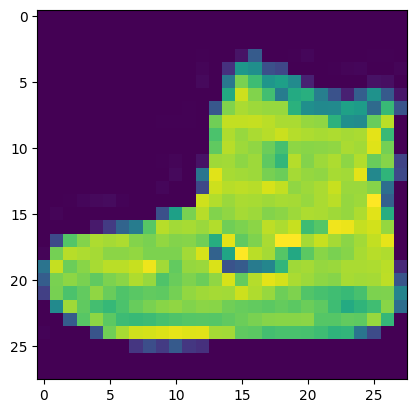

In [9]:
plt.figure()
plt.imshow(combined_images[0])
plt.grid(False)
plt.show()

## Imagenes del dataset aumentado

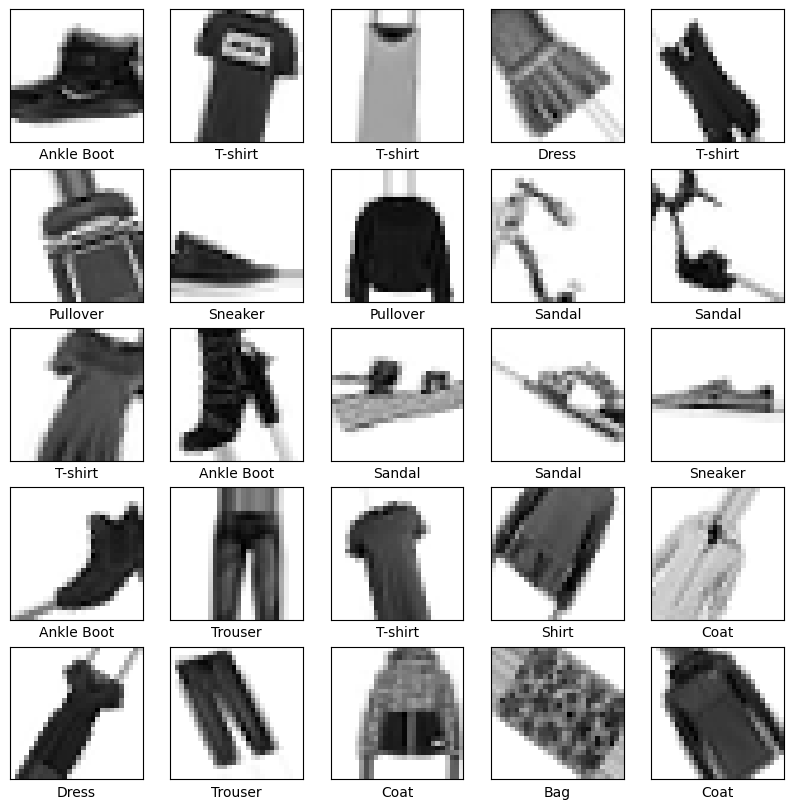

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(combined_images[i+60000], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(combined_labels[i])])
plt.show()

# Modelacion: Modelo 1 - Red Convolucional

In [11]:
model = keras.Sequential(
      [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),


        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),



        layers.Flatten(),

        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

optimizador = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizador,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

## Entrenamiento del modelo

In [13]:
History=model.fit(combined_images, combined_labels, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 30s 37ms/step - loss: 0.8890 - accuracy: 0.6835 - val_loss: 0.8756 - val_accuracy: 0.6759
Epoch 2/10
750/750 [==============================] - 27s 35ms/step - loss: 0.5790 - accuracy: 0.7945 - val_loss: 0.7380 - val_accuracy: 0.7300
Epoch 3/10
750/750 [==============================] - 27s 35ms/step - loss: 0.4968 - accuracy: 0.8242 - val_loss: 0.7607 - val_accuracy: 0.7106
Epoch 4/10
750/750 [==============================] - 27s 36ms/step - loss: 0.4472 - accuracy: 0.8408 - val_loss: 0.6540 - val_accuracy: 0.7507
Epoch 5/10
750/750 [==============================] - 26s 35ms/step - loss: 0.4130 - accuracy: 0.8531 - val_loss: 0.5956 - val_accuracy: 0.7814
Epoch 6/10
750/750 [==============================] - 27s 36ms/step - loss: 0.3890 - accuracy: 0.8604 - val_loss: 0.5883 - val_accuracy: 0.7845
Epoch 7/10
750/750 [==============================] - 27s 36ms/step - loss: 0.3650 - accuracy: 0.8697 - val_loss: 0.6359 - val_accuracy:

# Evaluacion del modelo

## Accuracy en el test set

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)

print('\nTest accuracy:', round(test_acc,2))


Test accuracy: 0.92


## Metricas de entrenamiento

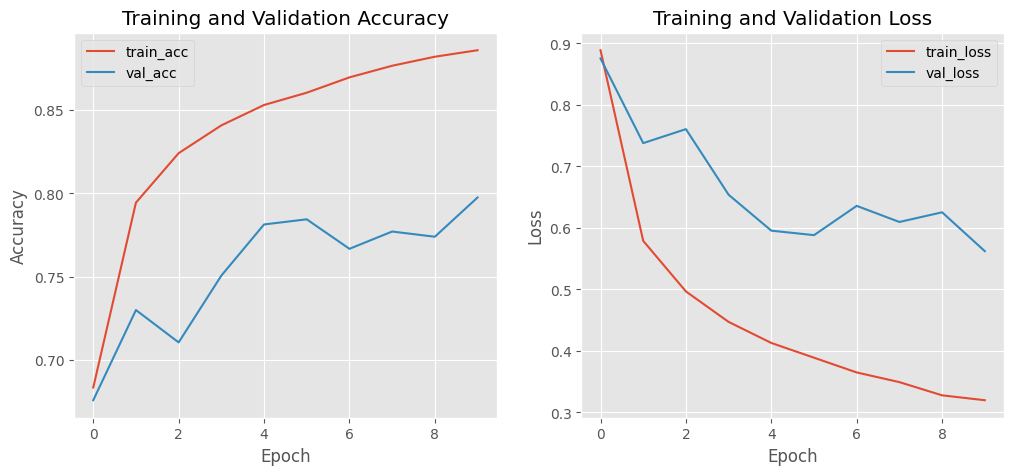

In [15]:
H = History
plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Metricas de clasificacion

In [16]:
predictions = model.predict(test_images)


y_pred_classes = np.argmax(predictions, axis=1)
reporte = classification_report(test_labels, y_pred_classes, target_names=class_names)

print(reporte)

313/313 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

     T-shirt       0.88      0.85      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.92      0.83      0.87      1000
       Dress       0.87      0.94      0.91      1000
        Coat       0.84      0.89      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.76      0.77      0.77      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle Boot       0.96      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Matriz de confusion

<Axes: >

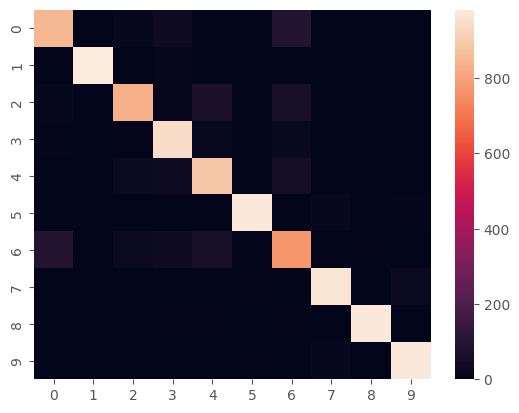

In [17]:
import seaborn as sns

conf_mat = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(conf_mat)

# Predicciones

In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[int(predicted_label)],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[int(predicted_label)].set_color('red')
  thisplot[int(true_label)].set_color('blue')

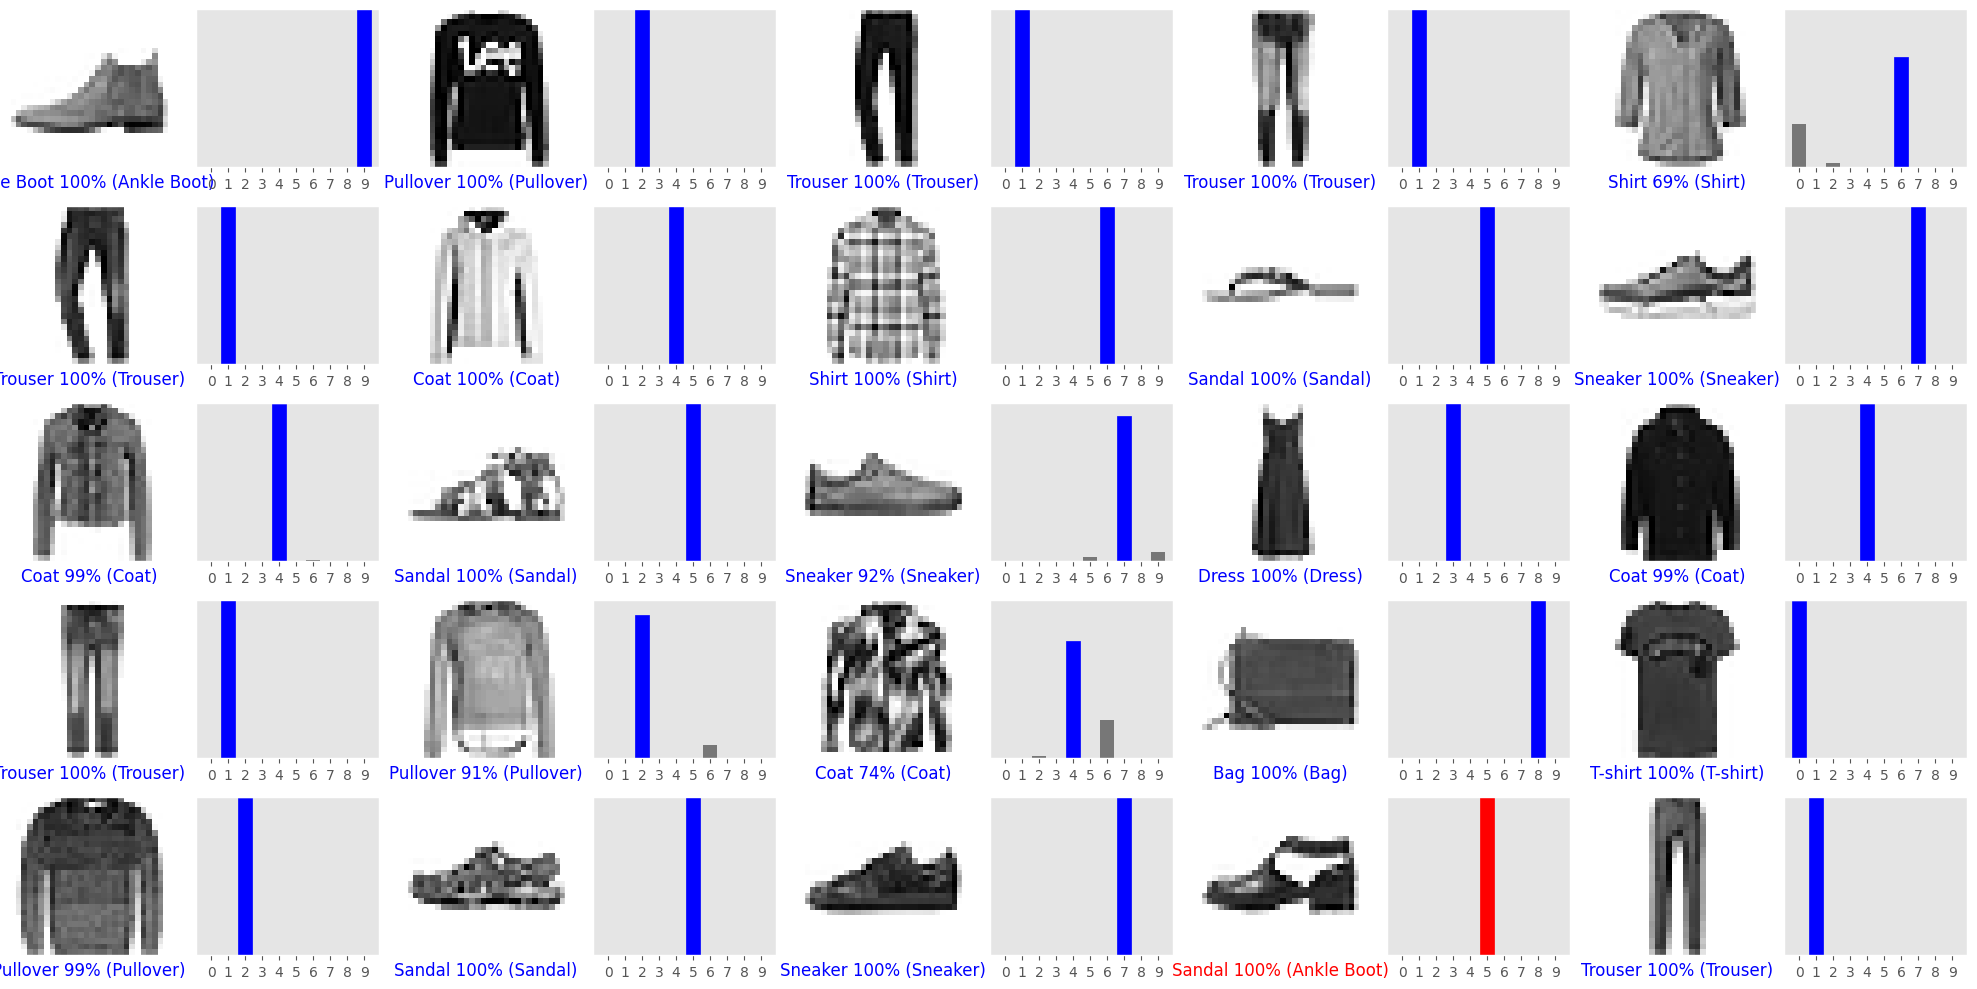

In [19]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()